<font size="5"> Simple Expected Goal model using SVM<font-size>

In [8]:
import pandas as pd
import numpy as np
import json

import matplotlib.pyplot as plt
plt.style.use(['ggplot'])

from sklearn.svm import SVC

## Data Collection

In [9]:
#data from https://figshare.com/collections/Soccer_match_event_dataset/4415000/2
with open('data/events_England.json') as f:
    data = json.load(f)
    

df_events = pd.DataFrame(data)
df_shots = df_events[df_events['subEventName'] == 'Shot']
shots_model = pd.DataFrame(columns = ['Goal','X','Y'])

In [10]:
df_events.head()

,eventId,subEventName,tags,playerId,positions,matchId,eventName,teamId,matchPeriod,eventSec,subEventId,id
0,8,Simple pass,[{'id': 1801}],25413,"[{'y': 49, 'x': 49}, {'y': 78, 'x': 31}]",2499719,Pass,1609,1H,2.758649,85,177959171
1,8,High pass,[{'id': 1801}],370224,"[{'y': 78, 'x': 31}, {'y': 75, 'x': 51}]",2499719,Pass,1609,1H,4.946850,83,177959172
2,8,Head pass,[{'id': 1801}],3319,"[{'y': 75, 'x': 51}, {'y': 71, 'x': 35}]",2499719,Pass,1609,1H,6.542188,82,177959173
3,8,Head pass,[{'id': 1801}],120339,"[{'y': 71, 'x': 35}, {'y': 95, 'x': 41}]",2499719,Pass,1609,1H,8.143395,82,177959174
4,8,Simple pass,[{'id': 1801}],167145,"[{'y': 95, 'x': 41}, {'y': 88, 'x': 72}]",2499719,Pass,1609,1H,10.302366,85,177959175


## Feature Engineering

In [6]:
#adapted from https://github.com/Friends-of-Tracking-Data-FoTD/SoccermaticsForPython/blob/master/3xGModel.py

for i, shot in df_shots.iterrows():
    
    header=0
    for shottags in shot['tags']:
        if shottags['id']==403:
            header=1
    #Only include non-headers        
    if not(header):        
        shots_model.at[i,'X']=100-shot['positions'][0]['x']
        shots_model.at[i,'Y']=shot['positions'][0]['y']
        shots_model.at[i,'C']=abs(shot['positions'][0]['y']-50)
    
        #Distance in metres and shot angle in radians.
        x=shots_model.at[i,'X']*105/100
        y=shots_model.at[i,'C']*65/100
        shots_model.at[i,'Distance']=np.sqrt(x**2 + y**2)
        a = np.arctan(7.32 *x /(x**2 + y**2 - (7.32/2)**2))
        if a<0:
            a=np.pi+a
        shots_model.at[i,'Angle'] =a
    
        #Was it a goal
        shots_model.at[i,'Goal']=0
        for shottags in shot['tags']:
                #Tags contain that its a goal
                if shottags['id']==101:
                    shots_model.at[i,'Goal']=1

shots_model['Goal'] = pd.to_numeric(shots_model['Goal'])
shots_model.reset_index(drop=True, inplace = True)

In [7]:
shots_model

,Goal,X,Y,C,Distance,Angle
0,1,12.0,41,9.0,13.891814,0.474451
1,0,15.0,52,2.0,15.803560,0.453823
2,0,19.0,33,17.0,22.805811,0.280597
3,0,25.0,30,20.0,29.292704,0.223680
4,0,10.0,39,11.0,12.703248,0.479051
...,...,...,...,...,...,...
7129,0,14.0,40,10.0,16.072959,0.413920
7130,0,28.0,45,5.0,29.579089,0.244789
7131,1,14.0,33,17.0,18.390011,0.319916
7132,0,12.0,62,12.0,14.818907,0.420593


## Fitting a SVM

In this experiment, the input will be the shooting positions X and Y and the target will be binary, indicating if the shot resulted in goal, or not

In [143]:
#SVM model

clf = SVC(C = 0.9, gamma ='auto', probability=True)
clf.fit(shots_model[['X', 'Y']], shots_model['Goal'])


SVC(C=0.9, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

## Plotting the results

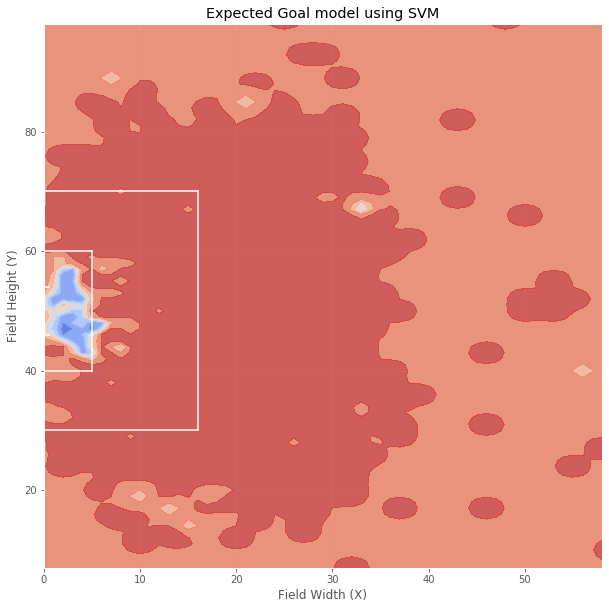

In [144]:
#Plot decision boudary using the entire field

X = shots_model[['X', 'Y']].values
y = shots_model['Goal']

def make_meshgrid(x, y, h=1):
    x_min, x_max = x.min(), x.max()
    y_min, y_max = y.min(), y.max()
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    Z = Z[:, 0].reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out



fig, ax = plt.subplots(figsize = (10, 10))
# title for the plots
# Set-up grid for plotting.
X0, X1 = X[:, 0], X[:, 1]
xx, yy = make_meshgrid(X0, X1)

plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
#ax.scatter(X0, X1, c=y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')
ax.set_xlabel('Field Width (X)')
ax.set_ylabel('Field Height (Y)')
ax.set_title('Expected Goal model using SVM')


ax.plot(np.arange(0, 17), [30] * 17, 'w-')
ax.plot(np.arange(0, 17), [70] * 17, 'w-')
ax.plot([16] * 41, 30+np.arange(0, 41), 'w-')


ax.plot(np.arange(0, 6), [40] * 6, 'w-')
ax.plot(np.arange(0, 6), [60] * 6, 'w-')
ax.plot([5] * 21, 40+np.arange(0, 21), 'w-')

ax.plot([0, 0.5], [46] * 2, 'w-')
ax.plot([0, 0.5], [54] * 2, 'w-')
ax.plot([0] * 9, 46+np.arange(0, 9), 'w-')


plt.show()


Analysing this simple xG model, we can see that the area closer to the defenders goal is the most probable location to score a goal (blue points). 
The light red zones are the ones with the lower probability of scoring (as the distance to goal is also higher).

This was a very basic approach, considering only X and Y positions.

In Future work, there are other interesting features to explore, namely:
- Distance to goal
- Shooting angle
- Goalkeeper position
- Defender position
- Pressure over the player